In [4]:
import os
import re
from collections import Counter
import pandas as pd
import numpy as np
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import kagglehub
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torch
from tqdm import tqdm


 # Download Data

In [5]:
data_dir = kagglehub.dataset_download("adityajn105/flickr8k")
print("Path to dataset files:", data_dir)

Path to dataset files: /home/josiah/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1


In [6]:
data_dir = '/home/josiah/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1'
images_dir = os.path.join(data_dir, "Images")
captions_file = os.path.join(data_dir, "captions.txt")

In [7]:
glove_dir = kagglehub.dataset_download("danielwillgeorge/glove6b100dtxt")
print("Path to dataset files:", glove_dir)

Path to dataset files: /home/josiah/.cache/kagglehub/datasets/danielwillgeorge/glove6b100dtxt/versions/1


In [8]:
glove_dir = '/home/josiah/.cache/kagglehub/datasets/danielwillgeorge/glove6b100dtxt/versions/1'
glove_file = os.path.join(glove_dir, "glove.6B.100d.txt")

# Data Processing

In [9]:
dataset = pd.read_csv(captions_file)
dataset.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

In [10]:
dataset['caption'] = dataset['caption'].apply(lambda x: re.sub(r"[^a-z0-9\s]", "", x.lower().strip()))
dataset.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  a child in a pink dress is climbing up a set o...  
1               a girl going into a wooden building   
2    a little girl climbing into a wooden playhouse   
3  a little girl climbing the stairs to her playh...  
4  a little girl in a pink dress going into a woo...

In [11]:
shuffled_image_names = pd.Series(dataset['image'].unique()).sample(frac=1, random_state=42)

In [12]:
num_images = len(shuffled_image_names)
train_imgs_filenames = shuffled_image_names[:int(num_images*0.6)]
validate_imgs_filenames = shuffled_image_names[int(num_images*0.6):int(num_images*0.8)]
test_imgs_filenames = shuffled_image_names[int(num_images*0.8):]

train_imgs = dataset.loc[dataset['image'].isin(train_imgs_filenames), :]
validate_imgs = dataset.loc[dataset['image'].isin(validate_imgs_filenames), :]
test_imgs = dataset.loc[dataset['image'].isin(test_imgs_filenames), :]

print(f'Total images: {num_images}')
print(f'Training images: {len(train_imgs_filenames)}')
print(f'Validation images: {len(validate_imgs_filenames)}')
print(f'Testing images: {len(test_imgs_filenames)}')

Total images: 8091
Training images: 4854
Validation images: 1618
Testing images: 1619


# Evaluation Metrics

In [13]:
import numpy as np
import nltk
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from torchmetrics.text.rouge import ROUGEScore
from torchmetrics.text.cider import CIDERD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Ensure any required NLTK resources are downloaded:
nltk.download('wordnet')  # for METEOR

def compute_bleu(references, hypotheses):
    """
    Computes BLEU-1, BLEU-2, BLEU-3, BLEU-4.
    
    Args:
        references (list): List of lists of reference captions (each caption is a list of tokens).
                           E.g., [ [ref1, ref2, ...], [ref1, ref2, ...], ...]
        hypotheses (list): List of tokenized hypothesis captions (each caption is a list of tokens).
    
    Prints BLEU-1, BLEU-2, BLEU-3, BLEU-4.
    """
    smooth = SmoothingFunction().method1
    bleu1 = corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0), smoothing_function=smooth)
    bleu2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth)
    bleu3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smooth)
    bleu4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth)
    print(f"BLEU-1: {bleu1:.4f}")
    print(f"BLEU-2: {bleu2:.4f}")
    print(f"BLEU-3: {bleu3:.4f}")
    print(f"BLEU-4: {bleu4:.4f}")


def compute_meteor(references, hypotheses):
    """
    Computes the METEOR score averaged over all examples.
    
    Args:
        references (list): List of lists of reference captions (each reference is a list of tokens).
        hypotheses (list): List of tokenized hypothesis captions.
    
    Prints the average METEOR score.
    """
    meteor_scores = []
    for refs, hyp in zip(references, hypotheses):
        # Convert each token list into a string.
        refs_str = [" ".join(r) for r in refs]
        hyp_str = " ".join(hyp)
        meteor_scores.append(meteor_score(refs_str, hyp_str))
    avg_meteor = sum(meteor_scores) / len(meteor_scores)
    print(f"METEOR: {avg_meteor:.4f}")


def compute_rouge_L(references, hypotheses):
    """
    Computes the ROUGE-L (F-measure) score: for each example, compute ROUGE-L for each reference,
    and then take the best (maximum) score. Finally, average these scores.
    
    Args:
        references (list): List of lists of reference captions (each caption is a list of tokens).
        hypotheses (list): List of tokenized hypothesis captions.
    
    Prints the average ROUGE-L score.
    """
    rouge = ROUGEScore()
    rouge_L_scores = []
    for refs, hyp in zip(references, hypotheses):
        hyp_str = " ".join(hyp)
        # Compute ROUGE-L for each reference and take the maximum.
        ref_scores = [rouge(hyp_str, " ".join(ref))['rougeL_fmeasure'].item() for ref in refs]
        rouge_L_scores.append(max(ref_scores))
    avg_rougeL = sum(rouge_L_scores) / len(rouge_L_scores)
    print(f"ROUGE-L: {avg_rougeL:.4f}")


def compute_cider(references, hypotheses):
    """
    Computes the CIDEr score over the dataset.
    
    Args:
        references (list): List of lists of reference captions (each caption is a list of tokens).
        hypotheses (list): List of tokenized hypothesis captions.
    
    Prints the CIDEr score.
    """
    ciderd_metric = CIDERD(n=4, sigma=6.0)
    # Prepare text for the metric: join tokens into strings.
    hyp_strs = [" ".join(h) for h in hypotheses]
    ref_strs = [[" ".join(r) for r in refs] for refs in references]
    score = ciderd_metric(hyp_strs, ref_strs)
    avg_cider = score.item()
    print(f"CIDEr: {avg_cider:.4f}")


def compute_tfidf_similarity(references, hypotheses):
    """
    Computes an average cosine similarity between each hypothesis and its best matching reference
    using TF-IDF representations.
    
    Args:
        references (list): List of lists of reference captions (each caption is a list of tokens).
        hypotheses (list): List of tokenized hypothesis captions.
    
    Prints the average cosine similarity.
    """
    vectorizer = TfidfVectorizer()
    similarities = []
    for refs, hyp in zip(references, hypotheses):
        hyp_str = " ".join(hyp)
        ref_strs = [" ".join(r) for r in refs]
        # Fit the vectorizer on the combination of the hypothesis and its references.
        texts = [hyp_str] + ref_strs
        tfidf = vectorizer.fit_transform(texts)
        # Compute cosine similarity between the hypothesis (first element) and each reference.
        sim = cosine_similarity(tfidf[0:1], tfidf[1:]).flatten()
        # Use the highest similarity score (or you could average them).
        similarities.append(np.max(sim))
    avg_similarity = np.mean(similarities)
    print(f"TFIDF Cosine Similarity: {avg_similarity:.4f}")


def evaluate_metrics(references, hypotheses):
    """
    Given a list of predictions and a list of ground truth (each being tokenized as lists of tokens),
    calculates and prints BLEU (1-4), METEOR, ROUGE-L, CIDEr, and TF-IDF cosine similarity.
    
    Args:
        references (list): List of references per example. Each element is a list of reference captions (each caption is a list of tokens).
        hypotheses (list): List of hypothesis captions (each caption is a list of tokens).
    """
    print("Evaluating Metrics:")
    compute_bleu(references, hypotheses)
    compute_meteor(references, hypotheses)
    compute_rouge_L(references, hypotheses)
    compute_cider(references, hypotheses)
    compute_tfidf_similarity(references, hypotheses)

ModuleNotFoundError: No module named 'torchmetrics.text.cider'

# CNN-LSTM

## Build Vocabulary

In [14]:
word_counter = Counter()

# use only the training data
for _, row in train_imgs.iterrows():
    word_counter.update(row['caption'].split())

vocab_words = list(word_counter.keys())
# Add special tokens
vocab = ["<PAD>", "<START>", "<END>", "<UNK>"] + vocab_words
vocab_size = len(vocab)
word2idx = {word: idx for idx, word in enumerate(vocab)}
idx2word = {idx: word for idx, word in enumerate(vocab)}
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 6993


In [15]:
embedding_dim = 100  # using 100d GloVe
embedding_matrix = np.zeros((vocab_size, embedding_dim), dtype=np.float32)
# For words not found in GloVe, we will keep the row as zeros (or could randomize)
found_words = 0
with open(glove_file, 'r', encoding='utf8') as f:
    for line in f:
        parts = line.split()
        word = parts[0]
        vec = np.array(parts[1:], dtype=np.float32)
        if word in word2idx:
            idx = word2idx[word]
            embedding_matrix[idx] = vec
            found_words += 1
print(f"Found {found_words} words in GloVe out of {vocab_size}")

Found 6363 words in GloVe out of 6993


In [18]:
class FlickrDataset(Dataset):
    def __init__(self, dataset_df, word2idx, transform=None, max_length=25, mode="train"):

        self.filenames = list(dataset_df['image'].unique())
        self.captions = dataset_df.groupby('image')['caption'].apply(list).to_dict()
        self.word2idx = word2idx
        self.transform = transform
        self.max_length = max_length
        self.mode = mode

        # In training mode, we'll treat each (image, caption) as separate entries for more variation
        if self.mode == "train":
            self.pairs = dataset_df.values.tolist()
        elif self.mode == "test":
            self.pairs = [[fname, self.captions[fname]] for fname in self.filenames]
        else:
            # In validation, we may just use one caption per image for evaluation or all for metrics
            self.pairs = [(fname, self.captions[fname][0]) for fname in self.filenames]  # using first caption
            # (We will handle multiple references in evaluation separately)

    def encode_caption(self,caption):
        tokens = caption.split()
        # Truncate if longer than max_length - 2 (for <START> and <END>)
        if len(tokens) > self.max_length - 2:
            tokens = tokens[:self.max_length-2]
        # Convert words to indices, with <UNK> for unseen
        caption_indices = [word2idx["<START>"]] + \
                          [word2idx.get(word, word2idx["<UNK>"]) for word in tokens] + \
                          [word2idx["<END>"]]
        # Pad to max_length
        if len(caption_indices) < self.max_length:
            caption_indices += [word2idx["<PAD>"]] * (self.max_length - len(caption_indices))
        return caption_indices

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        fname, caption = self.pairs[idx]
        # Load and transform image
        img_path = os.path.join(images_dir, fname)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        if self.mode in ['train', 'val']:
            caption_indices = self.encode_caption(caption)
            caption_tensor = torch.tensor(caption_indices, dtype=torch.long)
            return image, caption_tensor
        else:
            return image, caption

In [19]:
from PIL import Image
import torchvision.transforms as T

# Define image transform pipeline for training (could add augmentation here if desired)
IMG_SIZE = 224

# Evaluation (validation and test) transform pipeline (deterministic)
transforms = T.Compose([
    # Resize image to have the shorter side equal to 256 pixels while preserving aspect ratio
    T.Resize(256),
    # Center crop to the target size
    T.CenterCrop(IMG_SIZE),
    # Convert the PIL Image to a PyTorch Tensor (range [0, 1])
    T.ToTensor(),
    # Normalize using ImageNet parameters
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])


In [20]:
# Instantiate datasets
max_caption_len = 30
train_dataset = FlickrDataset(train_imgs, word2idx, transform=transforms, max_length=max_caption_len, mode="train")
val_dataset   = FlickrDataset(validate_imgs, word2idx, transform=transforms, max_length=max_caption_len, mode="val")
test_dataset  = FlickrDataset(test_imgs, word2idx, transform=transforms, max_length=max_caption_len, mode="test")

# DataLoaders (use shuffle for training, no shuffle for val/test)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False)  # test one image at a time if we want to examine outputs

## Build Model

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class EncoderCNN(nn.Module):
    def __init__(self, encoded_image_size=256, train_cnn=False, dropout_p=0.5):
        super(EncoderCNN, self).__init__()
        # Load pretrained ResNet50 and remove final fc layer
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)  # PyTorch >=1.12 provides weights like this
        modules = list(resnet.children())[:-1]  # remove last fc layer, keep avgpool
        self.cnn = nn.Sequential(*modules)      # CNN backbone
        self.fc = nn.Linear(resnet.fc.in_features, encoded_image_size)  # learn a transformation to desired dim
        # Freeze CNN weights if not training CNN
        for param in self.cnn.parameters():
            param.requires_grad = train_cnn  # if False, freeze, if True, fine-tune CNN

    def forward(self, images):
        # Expect images of shape (B,3,224,224)
        with torch.no_grad():
            features = self.cnn(images)  # shape (B, 2048, 1, 1)
        features = features.view(features.size(0), -1)  # flatten to (B, 2048)
        features = self.fc(features)  # (B, encoded_image_size)
        features = torch.relu(features)  # activation (optional)
        return features

class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1, dropout=0.6):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # Embedding layer
        self.embed = nn.Embedding(vocab_size, embed_size)
        # Initialize embeddings with GloVe weights
        self.embed.weight.data.copy_(torch.from_numpy(embedding_matrix))
        # (Optionally, freeze embedding weights here by setting requires_grad=False if desired)
        # LSTM to generate captions
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        # Final output layer to vocab
        self.fc_out = nn.Linear(hidden_size, vocab_size)
        # Linear layers to initialize hidden and cell from encoded image
        self.init_h = nn.Linear(hidden_size, hidden_size)
        self.init_c = nn.Linear(hidden_size, hidden_size)

    def forward(self, features, captions):
        """
        features: tensor (B, hidden_size) from EncoderCNN (encoded image features).
        captions: tensor (B, T) of token indices (including <START> and <END> and padded to length T).
                  We will feed in captions[:, :-1] as input (all but last token).
        """
        batch_size = features.size(0)
        # Initialize LSTM state
        h = self.init_h(features).unsqueeze(0)  # (1, B, hidden_size)
        c = self.init_c(features).unsqueeze(0)  # (1, B, hidden_size)
        # Embed captions
        embeddings = self.embed(captions)  # (B, T, embed_size)
        # We do not need to feed the last <END> token into the LSTM, so we use all except last step
        # (since at last input there is no next output to predict)
        embeddings = embeddings[:, :-1, :]  # (B, T-1, embed_size)
        # LSTM forward
        lstm_out, _ = self.lstm(embeddings, (h, c))  # lstm_out: (B, T-1, hidden_size)
        outputs = self.fc_out(lstm_out)              # (B, T-1, vocab_size)
        return outputs

    def generate_caption(self, features, max_length=20):
        """Generate a caption for an image (greedy search)."""
        # features: (1, hidden_size) for single image
        h = self.init_h(features).unsqueeze(0)
        c = self.init_c(features).unsqueeze(0)
        inputs = torch.tensor([[word2idx["<START>"]]], dtype=torch.long).to(device)  # start token
        caption_indices = []
        for t in range(max_length):
            embedding = self.embed(inputs)  # (1,1,embed_size)
            lstm_out, (h, c) = self.lstm(embedding, (h, c))
            output = self.fc_out(lstm_out.squeeze(1))  # (1, vocab_size)
            _, predicted_idx = output.max(1)  # predicted word index (greedy)
            predicted_idx = predicted_idx.item()
            if predicted_idx == word2idx["<END>"]:
                break
            caption_indices.append(predicted_idx)
            # next input to LSTM is the predicted word
            inputs = torch.tensor([[predicted_idx]], dtype=torch.long).to(device)
        # Convert indices to words, omit <END>
        caption_words = [idx2word[idx] for idx in caption_indices]
        return " ".join(caption_words)

/home/josiah/Image-Captioning/.venv/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn(


Epoch [1/5], Step [100/759], Avg Loss: 5.3091
Total gradient norm: 0.6640
Epoch [1/5], Step [200/759], Avg Loss: 4.3999
Total gradient norm: 0.7330
Epoch [1/5], Step [300/759], Avg Loss: 4.1197
Total gradient norm: 0.6474
Epoch [1/5], Step [400/759], Avg Loss: 3.9001
Total gradient norm: 0.6932
Epoch [1/5], Step [500/759], Avg Loss: 3.7527
Total gradient norm: 0.6614
Epoch [1/5], Step [600/759], Avg Loss: 3.6764
Total gradient norm: 0.5484
Epoch [1/5], Step [700/759], Avg Loss: 3.5873
Total gradient norm: 0.5846
Validation Loss after epoch 1: 3.4829
Epoch [2/5], Step [100/759], Avg Loss: 3.3932
Total gradient norm: 0.6975
Epoch [2/5], Step [200/759], Avg Loss: 3.3622
Total gradient norm: 0.6076
Epoch [2/5], Step [300/759], Avg Loss: 3.3352
Total gradient norm: 0.6452
Epoch [2/5], Step [400/759], Avg Loss: 3.2856
Total gradient norm: 0.6934
Epoch [2/5], Step [500/759], Avg Loss: 3.2483
Total gradient norm: 0.6592
Epoch [2/5], Step [600/759], Avg Loss: 3.2438
Total gradient norm: 0.6819


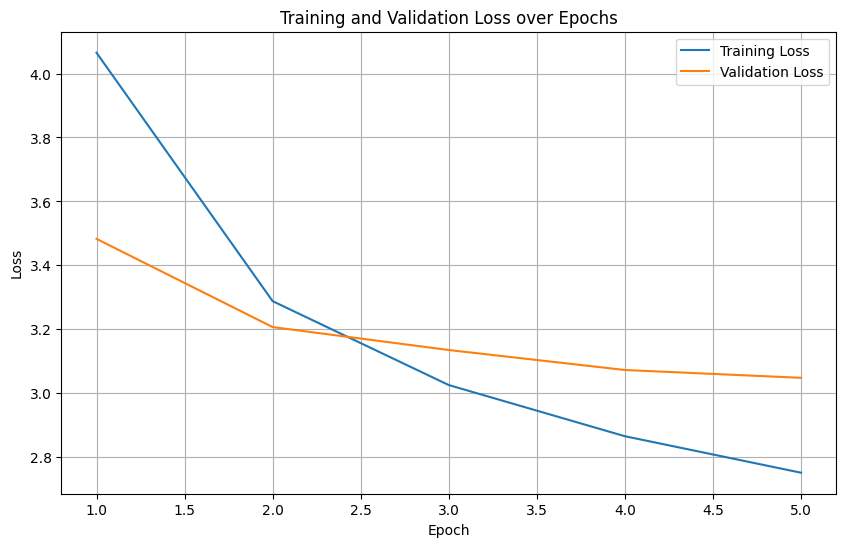

In [33]:
# Initialize models and optimizer
embed_size = 100         # word embedding size (GloVe dim)
hidden_size = 512        # LSTM hidden/cell size
encoder = EncoderCNN(encoded_image_size=hidden_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size).to(device)
# At start, only decoder parameters require grad (encoder CNN is frozen)
params = list(decoder.parameters()) + list(encoder.fc.parameters())  # include encoder.fc so it can learn to map features

optimizer = torch.optim.Adam(params, lr=1e-3, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss(ignore_index=word2idx["<PAD>"])

# Training loop
num_epochs = 5  # (For real training, more epochs, e.g., 20; but can adjust)
print_every = 100  # print loss every 100 batches

train_epoch_losses = []
val_epoch_losses = []
for epoch in range(num_epochs):
    encoder.train()
    decoder.train()
    total_loss = 0.0
    num_batches = 0
    running_loss = 0.0
    
    for batch_idx, (images, captions) in enumerate(train_loader):
        images, captions = images.to(device), captions.to(device)
        optimizer.zero_grad()
        # Forward pass
        features = encoder(images)                 # (B, hidden_size)
        outputs = decoder(features, captions)      # (B, T-1, vocab_size)
        # Prepare target: captions[:, 1:] (ignore <START> for target)
        targets = captions[:, 1:].to(device)       # (B, T-1)
        # Flatten outputs and targets to compute loss
        outputs = outputs.view(-1, vocab_size)     # ((B*(T-1)), vocab_size)
        targets = targets.contiguous().view(-1)    # ((B*(T-1)))
        loss = criterion(outputs, targets)
        # Backpropagate
        loss.backward()
        optimizer.step()

        total_grad_norm = 0.0
        for param in list(decoder.parameters()) + list(encoder.fc.parameters()):
            if param.grad is not None:
                grad_norm = param.grad.data.norm(2)
                total_grad_norm += grad_norm.item() ** 2
        
        running_loss += loss.item()
        total_loss += loss.item()
        num_batches += 1
        
        if (batch_idx + 1) % print_every == 0:
            avg_loss = running_loss / print_every
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], Avg Loss: {avg_loss:.4f}")
            running_loss = 0.0

            total_grad_norm = total_grad_norm ** 0.5
            print(f"Total gradient norm: {total_grad_norm:.4f}")
            optimizer.step()

    # Calculate average training loss for this epoch (over all batches)
    avg_train_loss = total_loss / num_batches if num_batches > 0 else 0
    train_epoch_losses.append(avg_train_loss)

    encoder_checkpoint_path = f"model/encoder_epoch_{epoch+1}.pth"
    decoder_checkpoint_path = f"model/decoder_lstm_epoch_{epoch+1}.pth"
    torch.save(encoder.state_dict(), encoder_checkpoint_path)
    torch.save(decoder.state_dict(), decoder_checkpoint_path)
    
    # --------------------------------------------------------------------------
    # Validation for this epoch
    # --------------------------------------------------------------------------
    decoder.eval()
    encoder.eval()
    val_loss = 0.0
    val_batches = 0
    with torch.no_grad():
        for images, captions in val_loader:
            images, captions = images.to(device), captions.to(device)
            features = encoder(images)
            outputs = decoder(features, captions)
            targets = captions[:, 1:].contiguous().view(-1)
            outputs = outputs.view(-1, vocab_size)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            val_batches += 1

    avg_val_loss = val_loss / val_batches if val_batches > 0 else 0
    val_epoch_losses.append(avg_val_loss)
    
    print(f"Validation Loss after epoch {epoch+1}: {avg_val_loss:.4f}")

# --------------------------------------------------------------------------
# Plotting the training and validation loss curves
# --------------------------------------------------------------------------
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_epoch_losses, label="Training Loss")
plt.plot(epochs, val_epoch_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()


## Evaluation

In [23]:
encoder_checkpoint = 'model/encoder_epoch_5.pth'
decoder_checkpoint = 'model/decoder_lstm_epoch_5.pth'

In [24]:
embed_size = 100         # word embedding size (GloVe dim)
hidden_size = 512        # LSTM hidden/cell size
encoder = EncoderCNN(encoded_image_size=hidden_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size).to(device)

# Load the state dictionaries into your models.
encoder.load_state_dict(torch.load(encoder_checkpoint, map_location=device))
decoder.load_state_dict(torch.load(decoder_checkpoint, map_location=device))

# Set the models to evaluation mode.
encoder.eval()
decoder.eval()

/home/josiah/Image-Captioning/.venv/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn(


DecoderRNN(
  (embed): Embedding(6993, 100)
  (lstm): LSTM(100, 512, batch_first=True, dropout=0.6)
  (fc_out): Linear(in_features=512, out_features=6993, bias=True)
  (init_h): Linear(in_features=512, out_features=512, bias=True)
  (init_c): Linear(in_features=512, out_features=512, bias=True)
)

In [25]:
def im_convert(tensor):
    """
    Convert an image tensor (normalized) into a NumPy array for visualization.
    Assumes image normalization with:
       mean = [0.485, 0.456, 0.406]
       std  = [0.229, 0.224, 0.225]
    """
    image = tensor.cpu().clone().detach().squeeze(0)
    image = image.numpy().transpose(1, 2, 0)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    return Image.fromarray((image * 255).astype(np.uint8))

hypotheses = []
references = []
pictures = []

# Get the first batch from the test loader
with torch.no_grad():
    for batch in tqdm(test_loader):
        test_image, captions = batch
        references.append([c[0] for c in captions])

        img_tensor = test_image.to(device)  # shape (1, 3, 224, 224)
        # Generate caption using the decoder's generate_caption() method
        features = encoder(img_tensor)
        generated_caption = decoder.generate_caption(features,max_length=30)
        hypotheses.append(generated_caption)
    
        # Convert the image tensor to NumPy for display
        image_np = im_convert(img_tensor)
        pictures.append(image_np)

100%|██████████| 1619/1619 [00:25<00:00, 62.90it/s]


### Ground Truth ###
a man lays on a bench while his dog sits by him 
a man lays on the bench to which a white dog is also tied 
a man sleeping on a bench outside with a white and black dog sitting next to him 
a shirtless man lies on a park bench with his dog 
man laying on bench holding leash of dog sitting on ground
### Prediction ###
a man in a blue shirt is sitting on a bench with a white dog


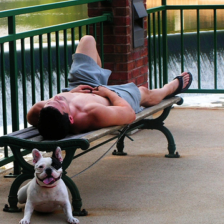

### Ground Truth ###
a man in an orange hat starring at something 
a man wears an orange hat and glasses 
a man with gauges and glasses is wearing a blitz hat 
a man with glasses is wearing a beer can crocheted hat 
the man with pierced ears is wearing glasses and an orange hat 
### Prediction ###
a man wearing a hat and hat is standing in a crowd


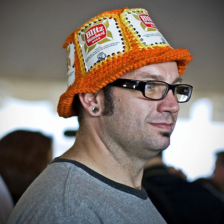

### Ground Truth ###
a child playing on a rope net 
a little girl climbing on red roping 
a little girl in pink climbs a rope bridge at the park 
a small child grips onto the red ropes at the playground 
the small child climbs on a red ropes on a playground 
### Prediction ###
two children are playing on a swing


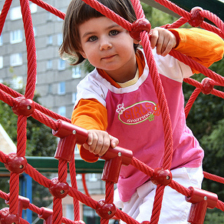

### Ground Truth ###
a black dog leaps over a log 
a grey dog is leaping over a fallen tree 
a large black dog leaps a fallen log 
a mottled black and grey dog in a blue collar jumping over a fallen tree 
the black dog jumped the tree stump 
### Prediction ###
a black dog is running through a grassy area


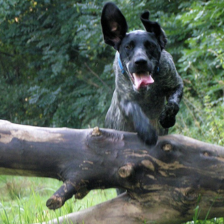

### Ground Truth ###
a child and a woman are at waters edge in a big city 
a large lake with a lone duck swimming in it with several people around the edge of it 
a little boy at a lake watching a duck 
a young boy waves his hand at the duck in the water surrounded by a green park 
two people are at the edge of a lake  facing the water and the city skyline 
### Prediction ###
a boy and a boy are playing in the water


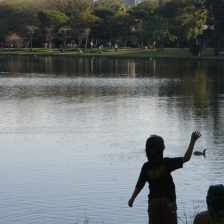

In [33]:
from PIL import Image
i = 0
for h, r, p in zip(hypotheses, references, pictures):
    # Display the image with both captions.
    print('### Ground Truth ###')
    for ref in r:
        print(ref)
    print('### Prediction ###')
    print(h)
    pil_img = Image.fromarray((p * 255).astype(np.uint8))
    pil_img.show()
    i+=1
    if i>=5:
        break

In [94]:
from aac_metrics import evaluate
corpus_scores, _ = evaluate(hypotheses, references)

{'bleu_1': tensor(0.5817, dtype=torch.float64), 'bleu_2': tensor(0.4004, dtype=torch.float64), 'bleu_3': tensor(0.2649, dtype=torch.float64), 'bleu_4': tensor(0.1741, dtype=torch.float64), 'meteor': tensor(0.1922, dtype=torch.float64), 'rouge_l': tensor(0.4386, dtype=torch.float64), 'cider_d': tensor(0.4511, dtype=torch.float64), 'spice': tensor(0.1329, dtype=torch.float64), 'spider': tensor(0.2920, dtype=torch.float64)}


In [95]:
for m, v in corpus_scores.items():
    print(f'{m}: {v}')

bleu_1: 0.5817031744172085
bleu_2: 0.40037783997410664
bleu_3: 0.26493226307895845
bleu_4: 0.1740561293719414
meteor: 0.19224145506643836
rouge_l: 0.4386021162486494
cider_d: 0.45114017870388623
spice: 0.13286444183224572
spider: 0.292002310268066


# Vision Transformer

In [34]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import VisionEncoderDecoderModel, AutoTokenizer, AutoFeatureExtractor, get_scheduler
import torchvision.transforms as T
import matplotlib.pyplot as plt

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "nlpconnect/vit-gpt2-image-captioning"
model = VisionEncoderDecoderModel.from_pretrained(model_name).to(device)
feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Set configuration parameters (if needed)
model.config.max_length = 20          # Maximum caption length
model.config.num_beams = 4            # Beam search width (if using beam search)
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.eos_token_id = tokenizer.eos_token_id
model.config.pad_token_id = tokenizer.pad_token_id

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 768,
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.51.1"
}

Config of the decoder: <class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'> is overwritten by shared decoder config: GPT2Config {
  "activation_function": "gelu_new",
  "add_cross_attention": true,
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "decoder_start_to

In [36]:
class FlickrDataset(Dataset):
    def __init__(self, dataset_df, tokenizer, transform=None, max_length=25, mode="train"):
        """
        Args:
            dataset_df (pd.DataFrame): DataFrame with at least "image" and "caption" columns.
            tokenizer: A HuggingFace tokenizer instance to tokenize captions.
            transform: Optional torchvision transforms to apply to images.
            max_length (int): Maximum tokenized caption length (including special tokens).
            mode (str): "train" or "val"/"test". In train mode, each image-caption pair is considered;
                        otherwise, one caption per image is used.
        """
        # List of unique image filenames
        self.filenames = list(dataset_df['image'].unique())
        # Group all captions per image into a dictionary: filename -> [list of captions]
        self.captions = dataset_df.groupby('image')['caption'].apply(list).to_dict()
        self.tokenizer = tokenizer
        self.transform = transform
        self.max_length = max_length
        self.mode = mode

        # In training mode, we'll treat each (image, caption) as separate entries for more variation
        if self.mode == "train":
            self.pairs = dataset_df.values.tolist()
        elif self.mode == "test":
            self.pairs = [[fname, self.captions[fname]] for fname in self.filenames]
        else:
            # In validation, we may just use one caption per image for evaluation or all for metrics
            self.pairs = [(fname, self.captions[fname][0]) for fname in self.filenames]  # using first caption
            # (We will handle multiple references in evaluation separately)

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        fname, caption = self.pairs[idx]
        # Construct the full path to the image.
        img_path = os.path.join(images_dir, fname)
        # Load the image and convert to RGB.
        image = Image.open(img_path).convert('RGB')
        # Apply any provided transforms.
        if self.transform:
            image = self.transform(images=image, return_tensors="pt")
            # Remove the extra batch dimension.
            image = image.pixel_values.squeeze(0)
            
        if self.mode in ['train', 'val']:
            tokenized = self.tokenizer(
                caption,
                max_length=self.max_length,
                padding="max_length",
                truncation=True,
                return_tensors="pt"
            )
            # Remove the extra batch dimension that the tokenizer returns.
            labels = tokenized.input_ids.squeeze(0)
            # Optionally: Replace padding token IDs with -100 so they are ignored in loss calculation.
            labels[labels == self.tokenizer.pad_token_id] = -100
            
            # Return a dictionary compatible with VisionEncoderDecoderModel inputs.
            return {"pixel_values": image, "labels": labels}
        else:
            return {"pixel_values": image, "labels": caption}


In [37]:
# Instantiate datasets
max_caption_len = 30
train_dataset = FlickrDataset(train_imgs, tokenizer, transform=feature_extractor, max_length=max_caption_len, mode="train")
val_dataset   = FlickrDataset(validate_imgs, tokenizer, transform=feature_extractor, max_length=max_caption_len, mode="val")
test_dataset  = FlickrDataset(test_imgs, tokenizer, transform=feature_extractor, max_length=max_caption_len, mode="test")

# DataLoaders (use shuffle for training, no shuffle for val/test)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False)

## No Fine Tuning

In [71]:
len(test_imgs.groupby('image')['caption'].apply(list).to_dict().items())

1619

In [69]:
model.eval()
num = 0

hypotheses = []
references = []
pictures = []
with torch.no_grad():
    for fname, captions in tqdm(test_imgs.groupby('image')['caption'].apply(list).to_dict().items()):

        img_path = os.path.join(images_dir, fname)
        # Load the image and convert to RGB.
        image = Image.open(img_path).convert('RGB')
        # Apply any provided transforms.
        pixel_values = feature_extractor(images=image, return_tensors="pt")
        pixel_values = pixel_values.pixel_values.to(device)

        # Generate captions using the model's generate() method.
        generated_ids = model.generate(pixel_values,
                                       max_length=model.config.max_length,
                                       num_beams=model.config.num_beams)

        generated_caption = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)


        references.append(captions)
        hypotheses.append(generated_caption[0])
        pictures.append(image)

100%|██████████| 1619/1619 [04:39<00:00,  5.79it/s]


### Ground Truth ###
a man lays on a bench while his dog sits by him 
a man lays on the bench to which a white dog is also tied 
a man sleeping on a bench outside with a white and black dog sitting next to him 
a shirtless man lies on a park bench with his dog 
man laying on bench holding leash of dog sitting on ground
### Prediction ###
a man and a woman laying on a bench 


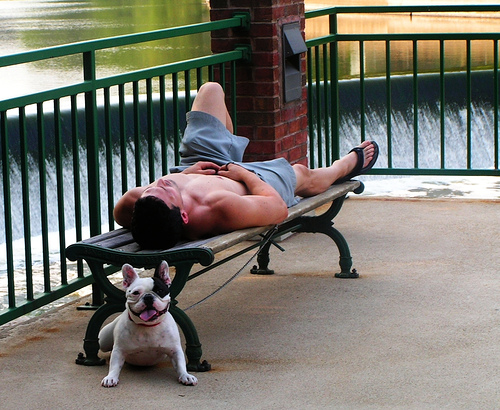

### Ground Truth ###
a man in an orange hat starring at something 
a man wears an orange hat and glasses 
a man with gauges and glasses is wearing a blitz hat 
a man with glasses is wearing a beer can crocheted hat 
the man with pierced ears is wearing glasses and an orange hat 
### Prediction ###
a man wearing a hat 


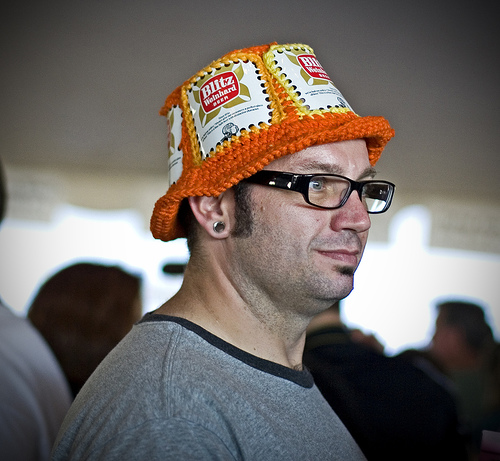

### Ground Truth ###
a child playing on a rope net 
a little girl climbing on red roping 
a little girl in pink climbs a rope bridge at the park 
a small child grips onto the red ropes at the playground 
the small child climbs on a red ropes on a playground 
### Prediction ###
a little girl in a red shirt and a little girl in a red shirt 


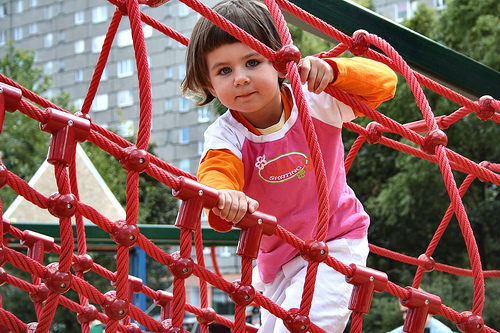

### Ground Truth ###
a black dog leaps over a log 
a grey dog is leaping over a fallen tree 
a large black dog leaps a fallen log 
a mottled black and grey dog in a blue collar jumping over a fallen tree 
the black dog jumped the tree stump 
### Prediction ###
a black dog standing on a tree stump 


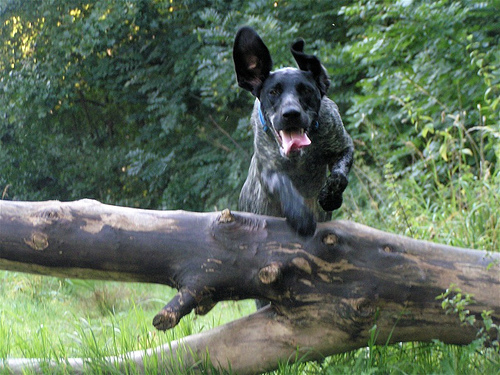

### Ground Truth ###
a child and a woman are at waters edge in a big city 
a large lake with a lone duck swimming in it with several people around the edge of it 
a little boy at a lake watching a duck 
a young boy waves his hand at the duck in the water surrounded by a green park 
two people are at the edge of a lake  facing the water and the city skyline 
### Prediction ###
two people playing a game of frisbee 


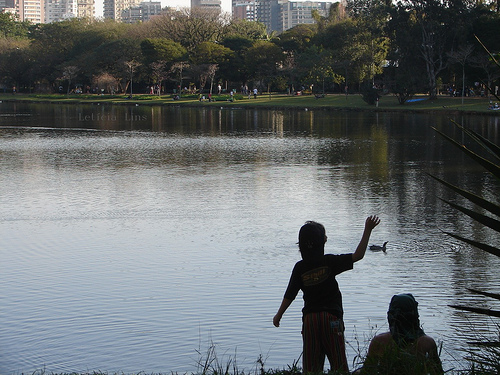

In [72]:
from PIL import Image
i = 0
for h, r, p in zip(hypotheses, references, pictures):
    # Display the image with both captions.
    print('### Ground Truth ###')
    for ref in r:
        print(ref)
    print('### Prediction ###')
    print(h)
    p.show()
    i+=1
    if i>=5:
        break

In [73]:
from aac_metrics import evaluate
corpus_scores, _ = evaluate(hypotheses, references)
for m, v in corpus_scores.items():
    print(f'{m}: {v}')

bleu_1: 0.6052422684623692
bleu_2: 0.4138939073491213
bleu_3: 0.27060945471868575
bleu_4: 0.17566334220757127
meteor: 0.18723908832150726
rouge_l: 0.43817445985171216
cider_d: 0.4557941617854955
spice: 0.13991394456517217
spider: 0.2978540531753338


## Fine Tuning

In [64]:
import torch
from transformers import get_scheduler
from tqdm import tqdm

# Set your device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assume your model, feature_extractor, and tokenizer are already set up as follows:
# model_name = "nlpconnect/vit-gpt2-image-captioning"
# model = VisionEncoderDecoderModel.from_pretrained(model_name).to(device)
# feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
# tokenizer = AutoTokenizer.from_pretrained(model_name)
#
# model.config.max_length = 20          
# model.config.num_beams = 4            
# model.config.decoder_start_token_id = tokenizer.bos_token_id
# model.config.eos_token_id = tokenizer.eos_token_id
# model.config.pad_token_id = tokenizer.pad_token_id

# Initialize the optimizer: using standard Adam optimizer here
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

# Specify number of epochs
num_epochs = 3
# Calculate total number of training steps
num_training_steps = num_epochs * len(train_loader)

# Create a learning rate scheduler (optional)
lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,  # Adjust if needed
    num_training_steps=num_training_steps
)

# Set the model to training mode
model.train()

# Create a progress bar for monitoring training steps
progress_bar = tqdm(range(num_training_steps))

# Training loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    for batch in train_loader:
        # Each batch should include the necessary inputs: images and text data
        pixel_values = batch["pixel_values"].to(device)
        # Tokenized inputs for the caption text
        input_ids = batch["labels"].to(device)
        # Optionally, if your batch contains an attention_mask, move it to the same device
        attention_mask = batch.get("attention_mask")
        if attention_mask is not None:
            attention_mask = attention_mask.to(device)
        # The target labels for language modeling (typically matching input_ids)
        labels = batch["labels"].to(device)

        # Forward pass: compute the outputs and loss from the model
        outputs = model(pixel_values=pixel_values, labels=labels, decoder_attention_mask=attention_mask)
        loss = outputs.loss

        # Zero out the gradients from previous iteration
        optimizer.zero_grad()
        # Backward pass: compute gradients of the loss with respect to parameters
        loss.backward()
        # Update model parameters
        optimizer.step()
        # Step the learning rate scheduler for the next iteration
        lr_scheduler.step()

        # Update progress bar
        progress_bar.update(1)

    # Optionally, output training loss for the current epoch
    print(f"Loss after epoch {epoch+1}: {loss.item():.4f}")



  0%|          | 0/2277 [00:00<?, ?it/s]

Epoch 1/3


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.
  0%|          | 3/2277 [00:04<47:08,  1.24s/it]  

KeyboardInterrupt: 

In [30]:
save_directory = "model/trained_vit_gpt2_captioning_model"

# Save the model (configuration and weights)
model.save_pretrained(save_directory)

# Save the tokenizer
tokenizer.save_pretrained(save_directory)

/home/josiah/Image-Captioning/.venv/lib/python3.11/site-packages/transformers/modeling_utils.py:3339: UserWarning: Moving the following attributes in the config to the generation config: {'num_beams': 4}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


('model/trained_vit_gpt2_captioning_model/tokenizer_config.json',
 'model/trained_vit_gpt2_captioning_model/special_tokens_map.json',
 'model/trained_vit_gpt2_captioning_model/vocab.json',
 'model/trained_vit_gpt2_captioning_model/merges.txt',
 'model/trained_vit_gpt2_captioning_model/added_tokens.json',
 'model/trained_vit_gpt2_captioning_model/tokenizer.json')

/home/josiah/Image-Captioning/.venv/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:670: UserWarning: `num_beams` is set to None - defaulting to 1.
  warnings.warn("`num_beams` is set to None - defaulting to 1.", UserWarning)


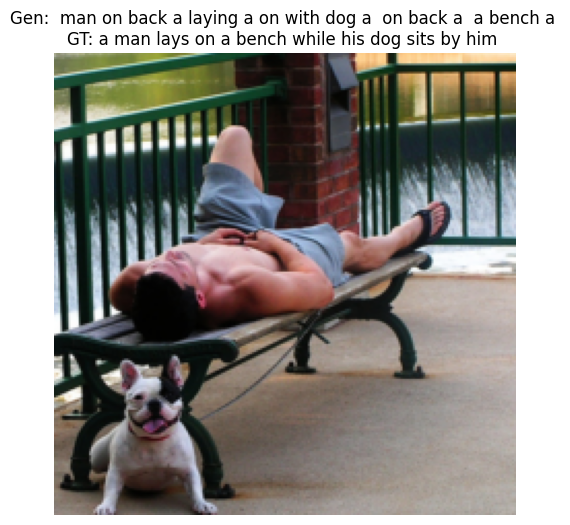

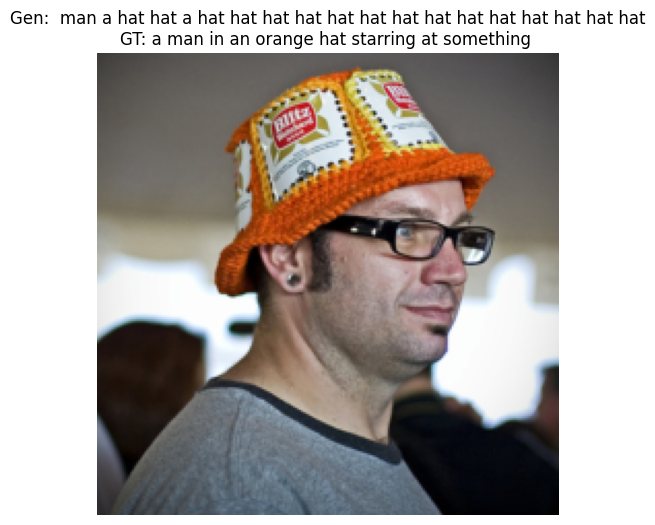

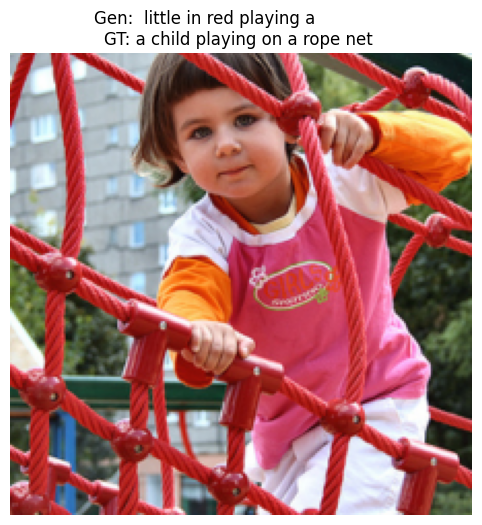

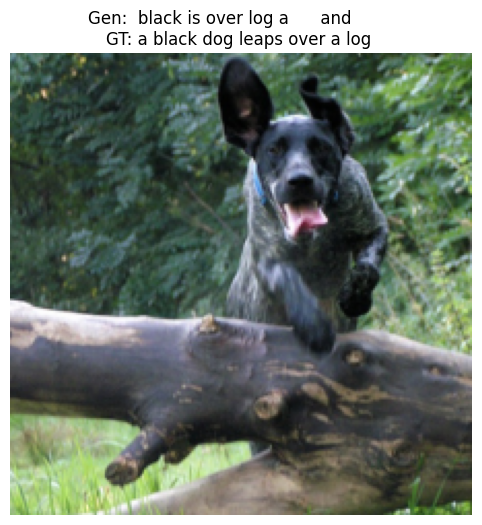

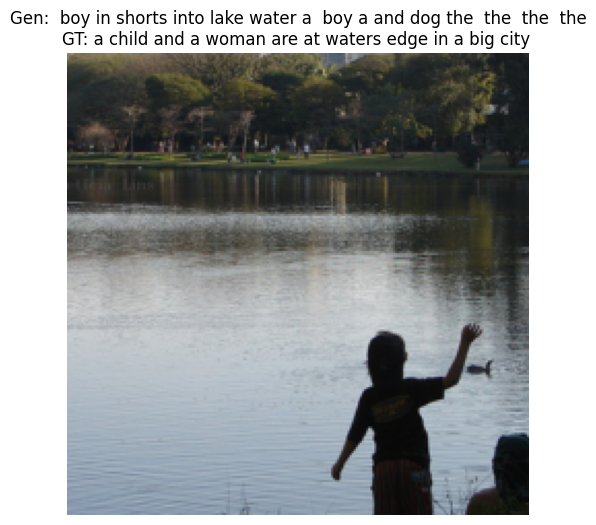

In [31]:
def im_convert(image_tensor):
    """
    Convert a normalized image tensor to a NumPy array suitable for displaying with matplotlib.
    Assumes image normalization with mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].
    """
    image_tensor = image_tensor.cpu().clone().detach().squeeze(0)
    image_np = image_tensor.numpy().transpose(1, 2, 0)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image_np = std * image_np + mean
    image_np = np.clip(image_np, 0, 1)
    return image_np

# Set the model to evaluation mode
model.eval()
num = 0
with torch.no_grad():
    # Get one batch from the train DataLoader (or change to your validation/test loader)
    for batch in test_loader:
        # Move pixel_values and labels to device.
        pixel_values = batch["pixel_values"].to(device)  # shape: (B, C, H, W)
        labels = batch["labels"].to(device)              # shape: (B, max_length)
        
        # Generate captions using the model's generate() method.
        generated_ids = model.generate(pixel_values,
                                       max_length=model.config.max_length,
                                       num_beams=model.config.num_beams)
        generated_captions = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
        
        # Prepare ground truth captions: Replace -100 with pad_token_id for decoding.
        gt_labels = labels.clone()
        gt_labels[gt_labels == -100] = tokenizer.pad_token_id
        ground_truth_captions = tokenizer.batch_decode(gt_labels, skip_special_tokens=True)
        
        # Loop through each image in the batch.
        for i in range(len(generated_captions)):
            # Extract the i-th image tensor and de-normalize it for display.
            image_tensor = pixel_values[i:i+1]
            image_np = im_convert(image_tensor)
            
            # Get the generated and ground truth captions.
            gen_caption = generated_captions[i]
            gt_caption = ground_truth_captions[i]
            
            # Display the image with both captions.
            plt.figure(figsize=(8, 6))
            plt.imshow(image_np)
            plt.title(f"Gen: {gen_caption}\nGT: {gt_caption}", fontsize=12)
            plt.axis("off")
            plt.show()
        
        num +=1
        if num >=5:
            break

# Evaluation

## CNN LSTM

## Vision Encoder Decoder Model

In [2]:
import torch
from transformers import VisionEncoderDecoderModel, AutoFeatureExtractor, AutoTokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_path = "./model/trained_vit_gpt2_captioning_model"
model = VisionEncoderDecoderModel.from_pretrained(model_path).to(device)

feature_extractor = AutoFeatureExtractor.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

model.config.max_length = 20
model.config.num_beams = 4
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.eos_token_id = tokenizer.eos_token_id
model.config.pad_token_id = tokenizer.pad_token_id

print("Model max_length:", model.config.max_length)

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 768,
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.51.1"
}

Config of the decoder: <class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'> is overwritten by shared decoder config: GPT2Config {
  "activation_function": "gelu_new",
  "add_cross_attention": true,
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "decoder_start_to

OSError: ./model/trained_vit_gpt2_captioning_model does not appear to have a file named preprocessor_config.json. Checkout 'https://huggingface.co/./model/trained_vit_gpt2_captioning_model/tree/main' for available files.